In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from IPython.display import Markdown as md
from IPython.display import display, display_html, display_markdown, HTML, Markdown as md
import time
import seaborn as sns
import math
from typing import List, Tuple, Dict, Any

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN, MeanShift, SpectralClustering, AgglomerativeClustering, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, make_scorer, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [51]:
%%html
<style>
@import url('https://fonts.googleapis.com/css2?family=DM+Sans:ital,opsz,wght@0,9..40,100..1000;1,9..40,100..1000&display=swap');
div.text_cell {font-family : DM Sans, sans-serif !important;}
pre {font-family : DM Sans, sans-serif !important;}
</style>

# **Clustering and Model Comparison Template** 
This Notebook compares the performance of different types of clustering models on a dataset provided by the user. It is meant to assist in the model selection process, helping users discern the most suitible clustering technique for their dataset. Users should store data in the data directory.
## **Clustering**

## Load In Data and Select Columns to Drop

In [52]:
DATA_FILE_NAME: str = "clustering_customer_data.csv"
COLUMNS_TO_DROP: list[str] = ["CUST_ID"]  # We don't need the customer ID for clustering


def display_dataframe(df: pd.DataFrame, font_size: int = 20) -> None:
    """
    Displays the passed in DataFrame with the specified font size.

    Args:
        df (pd.DataFrame): The DataFrame to be displayed.
        font_size (int): The font size at which the DataFrame should be displayed.

    Returns:
        None
    """
    # Convert the DataFrame to HTML
    df_html = df.to_html()
    # Apply the font size directly to the HTML
    styled_html = f'<div style="font-size: {font_size}px;">{df_html}</div>'
    display_html(HTML(styled_html))
    

def display_text(text: str, font_size: int = 16, font_weight: str = 'normal') -> None:
    """
    Displays the passed in text with the specified font size and font weight.

    Args:
        text (str): The text to be displayed.
        font_size (int): The font size at which the text should be displayed.
        font_weight (str): The font weight (e.g., 'normal', 'bold', 'bolder', 'lighter', or numeric value from 100 to 900).

    Returns:
        None
    """
    # Apply the font size and font weight directly to the HTML
    styled_html = f'<div style="font-size: {font_size}px; font-weight: {font_weight};">{text}</div>'
    display_html(HTML(styled_html))
    

def load_data(file_name: str = DATA_FILE_NAME, dropped_columns = COLUMNS_TO_DROP) -> pd.DataFrame:
    """
    Loads in user's input file as a pandas DataFrame.
    
    Args:
        file_name (str): Name of file containing data for clustering
        dropped_columns (list[str]): List of columns to drop from the dataframe
    Returns:
        pd.DataFrame: Dataframe of variable values for all data entries
    """
    
    file_name = "data/" + file_name
    file_extension = file_name.split(".")[-1]

    if file_extension == "csv":
        df = pd.read_csv(file_name)
    elif file_extension in ["xls", "xlsx"]:
        df = pd.read_excel(file_name)
    elif file_extension == "json":
        df = pd.read_json(file_name)
    else:
        raise ValueError("Unsupported file format or misspelled file name. Please upload a CSV, Excel, or JSON file and ensure the file name is spelled correctly.")
    
    df.drop_duplicates(inplace = True)
    df.drop(columns = dropped_columns, inplace = True)
    
    return df

data_df = load_data()
initial_number_of_entries, number_of_variables = data_df.shape
display_text(f"Initial Number of Entries: {initial_number_of_entries}", font_size = 18)
display_text(f"Number of Variables: {number_of_variables}", font_size = 18)
display_dataframe(data_df.head(), font_size = 16)


Initial Number of Entries: 8950

Number of Variables: 17

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


### **Dataset Missing Value Information**

In [53]:
numerical_variables: list[str] = list(data_df.select_dtypes(include = np.number).columns)
display_markdown(md(f"### **Numerical Variables:** {numerical_variables}"))

categorical_variables: list[str] = list(data_df.select_dtypes(exclude = np.number).columns)
display_markdown(md(f"### **Categorical Variables:** {categorical_variables}"))

# Automatically select columns with missing values
numerical_variables_with_missing_values: list[str] = data_df[numerical_variables].columns[data_df[numerical_variables].isnull().any()].tolist()
categorical_variables_with_missing_values: list[str] = data_df[categorical_variables].columns[data_df[categorical_variables].isnull().any()].tolist()


def display_missing_values_information(df: pd.DataFrame = data_df,
                                       numerical_variables: list[str] = numerical_variables_with_missing_values,
                                       categorical_variables: list[str] = categorical_variables_with_missing_values,
                                       number_of_entries: int = initial_number_of_entries,
                                       show_missing_type: bool = False) -> None:
    """
    This function provides a comprehensive summary of missing values in a DataFrame, including the number and
    percentage of missing values for each column, the type of missing values (if specified), and a preview of 
    entries with missing values. It also computes the total number of entries and the number of entries with missing values,
    along with the impact of dropping all rows with missing values.

    Args:
        df (pd.DataFrame): The DataFrame to analyze for missing values. Defaults to `data_df`.
        numerical_variables (list[str]): List of numerical columns to check for missing values. Defaults to `numerical_variables_with_missing_values`.
        categorical_variables (list[str]): List of categorical columns to check for missing values. Defaults to `categorical_variables_with_missing_values`.
        number_of_entries (int): The initial number of entries in the DataFrame. Defaults to `initial_number_of_entries`.
        show_missing_type (bool): If True, displays the type of missing values (either `np.nan` or `None`). Defaults to `False`.

    Returns:
        None
    """
    variables_with_missing_values: list[str] = numerical_variables + categorical_variables
    
    if len(variables_with_missing_values) != 0:
        print()
        
        if show_missing_type:
            # The next two if statements show the missing value type for each column with missing values,
            # a necessary argument for imputation functions. Only works if missing value is either np.nan or None.
            if len(categorical_variables_with_missing_values) != 0:    
                display_markdown(md(f"### **Missing Value Type for Categorical Variables with Missing Values (either np.nan or None)**"))
                
                for column in categorical_variables_with_missing_values:
                    missing_values = df[column][df[column].isnull()]
                    missing_type = type(missing_values.iloc[0])
                    
                    if pd.isna(missing_values.iloc[0]):
                        display_markdown(md(f"* #### **{column}**: np.nan"))
                    else:
                        display_markdown(md(f"* #### **{column}**: {str(missing_type)}"))
            
            if len(numerical_variables_with_missing_values) != 0:
                display_markdown(md(f"### **Missing Value Type for Numerical Variables with Missing Values (either np.nan or None)**"))
                
                for column in categorical_variables_with_missing_values:
                    missing_values = df[column][df[column].isnull()]
                    missing_type = type(missing_values.iloc[0])
                    
                    if pd.isna(missing_values.iloc[0]):
                        display_markdown(md(f"* #### **{column}**: np.nan"))
                    else:
                        display_markdown(md(f"* #### **{column}**: {str(missing_type)}"))
                    
        
        print()
        entries_with_missing_values_df: pd.DataFrame = df[variables_with_missing_values][df[variables_with_missing_values].isnull().any(axis = "columns")]
        number_of_entries_with_missing_values: int = len(entries_with_missing_values_df)
        percent_of_entries_with_missing_values: float = (number_of_entries_with_missing_values / number_of_entries) * 100
        total_number_of_missing_values: int = df[variables_with_missing_values].isnull().sum().sum()
        
        display_markdown(md(f"### **Missing Values by Variable**"))
        
        for column in variables_with_missing_values:
            column_missing_values: int = df[column].isnull().sum()
            percent_missing_values: float = (column_missing_values / number_of_entries) * 100
            
            if column_missing_values != 0:
                display_markdown(md(f"* #### **{column}**: {column_missing_values} ({percent_missing_values:.2f}% of Entries)"))
            
        print()
        display_markdown(md(f"### **Total Number of Entries:** {number_of_entries}"))
        display_markdown(md(f"### **Total Number of Entreis with at Least One Missing Value:** {number_of_entries_with_missing_values} ({percent_of_entries_with_missing_values:.2f}% of Entries)"))
        display_markdown(md(f"### **Number of Entries if all Rows with Missing Values are Dropped:** {number_of_entries - number_of_entries_with_missing_values}"))
        display_markdown(md(f"### **Total Number of Missing Values:** {total_number_of_missing_values}"))
        print()
        display_markdown(md("### Up to First 5 Entries with Missing Values"))
        display_dataframe(entries_with_missing_values_df.head(), font_size = 20)
    else:
        print()
        display_markdown(md("### **No Missing Values in Dataset**"))
        

display_missing_values_information()

### **Numerical Variables:** ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']

### **Categorical Variables:** []

### **Missing Values by Variable**

* #### **CREDIT_LIMIT**: 1 (0.01% of Entries)

* #### **MINIMUM_PAYMENTS**: 313 (3.50% of Entries)

### **Total Number of Entries:** 8950

### **Total Number of Entreis with at Least One Missing Value:** 314 (3.51% of Entries)

### **Number of Entries if all Rows with Missing Values are Dropped:** 8636

### **Total Number of Missing Values:** 314

### Up to First 5 Entries with Missing Values

,CREDIT_LIMIT,MINIMUM_PAYMENTS
3,7500.0,NaN
45,2400.0,NaN
47,4200.0,NaN
54,1000.0,NaN
55,6000.0,NaN


## **Handle Missing Values**

In [54]:
def drop_rows_with_missing_values(df: pd.DataFrame = data_df) -> pd.DataFrame:
    """
    Drops all rows with missing values from the DataFrame and splits dataset into feature dataframe and target series.
    Also prints number of entries of returned feature dataframe and target series to ensure they are equal.
    
    Args:
        df (pd.DataFrame): DataFrame containing loded in data
        target_variable_comlumn (str): Name of the target variable column
    Returns:
        pd.DataFrame: DataFrame with missing values dropped
    """
    
    original_number_of_entries = len(df)
    dropna_df = df.dropna()
    new_number_of_entries = len(dropna_df)
    number_of_entries_dropped = original_number_of_entries - new_number_of_entries
    
    display_markdown(md(f"### drop_rows_with_missing_values Results: {number_of_entries_dropped} Entries Dropped"))
    display_markdown(md(f"### New Number of Entries: {new_number_of_entries}"))
    
    return dropna_df


def impute_missing_values(df: pd.DataFrame = data_df,
                          numerical_variables_to_impute: list[str] = numerical_variables_with_missing_values,
                          categorical_variables_to_impute: list[str] = categorical_variables_with_missing_values) -> pd.DataFrame:
    """
    Imputes missing values in the DataFrame with either the median value (for numerical features) or the most frequent value (for categorical features)
    and splits dataset into feature dataframe and target series. Also prints number of entries of returned feature dataframe and target series to ensure they are equal.
    
    Args:
        df (pd.DataFrame): DataFrame containing loded in data.
        target_variable_column (str): Name of the target variable column
    Returns:
        impute_df (pd.DataFrame): DataFrame with missing values imputed
    """
    impute_df = df.copy()
    
    numerical_imputer = SimpleImputer(strategy = "median")
    categorical_imputer = SimpleImputer(strategy = "most_frequent")
    
    impute_df[numerical_variables_to_impute] = numerical_imputer.fit_transform(impute_df[numerical_variables_to_impute])
    impute_df[categorical_variables_to_impute] = categorical_imputer.fit_transform(impute_df[categorical_variables_to_impute])
    
    display_markdown(md("### Missing Values Imputed"))
    
    return impute_df


data_df = drop_rows_with_missing_values()

### drop_rows_with_missing_values Results: 314 Entries Dropped

### New Number of Entries: 8636

## **Handle Outliers/Eronious Entries**

In [56]:
display_text("Numerical Variables Information", font_size = 22, font_weight = 'bold')
display_dataframe(data_df.describe(), 16) 
print()


def visualize_outliers(df: pd.DataFrame,
                       columns_to_check: list[str] = None,
                       iqr_multiplier: float = 1.5,
                       remove: bool = False,
                       remove_option: str = 'both',
                       display: bool = True,) -> pd.DataFrame:
    """
    Creates a boxplot-  for the columns in the input DataFrame (df) given by columns_to_check. Calculates outliers using the interquartile range (IQR) method
    and gives users the option to remove 
    
    Args:
        df (pd.DataFrame): DataFrame containing the data
        iqr_multiplier (float): Multiplier for the interquartile range to define outliers
        columns_to_check (list[str]): List of columns to check for outliers. If None, all numerical columns will be checked.
        remove (bool): If True, returns a DataFrame with outliers removed.
        remove_option (str): Option to remove 'both', 'upper', or 'lower' outliers.
        display (bool): If True, displays boxplots of each column with outliers and their lower and upper bounds.
    
    Returns:
        pd.DataFrame: DataFrame with outliers removed if remove is True, otherwise the original DataFrame
    """
    if columns_to_check is None:
        columns_to_check = df.select_dtypes(include=[np.number]).columns
    else:
        columns_to_check = [col for col in columns_to_check if (col in df.columns)]
    
    outlier_indices = set()
    
    for col in columns_to_check:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - iqr_multiplier * iqr
        upper_bound = q3 + iqr_multiplier * iqr
        
        if display:
            plt.figure(figsize=(10, 6))
            ax = sns.boxplot(x=df[col])
            plt.title(f'Boxplot of {col}')
            
            # Add vertical red dotted lines for lower and upper bounds if within the plot's x-axis limits
            x_min, x_max = ax.get_xlim()
            if x_min <= lower_bound <= x_max:
                plt.axvline(lower_bound, color='red', linestyle='dotted', linewidth=1)
            if x_min <= upper_bound <= x_max:
                plt.axvline(upper_bound, color='red', linestyle='dotted', linewidth=1)
            
            # Create legend
            legend_lines = [Line2D([0], [0], color='red', linestyle='dotted', linewidth=1)]
            legend_labels = ['Lower/Upper Bound']
            plt.legend(legend_lines, legend_labels, loc='upper right')
            
            plt.show()
        
            display_text(f"{col}:", font_size = 18, font_weight = 'bold')
            display_text(f"- Lower Bound for Outliers: {lower_bound}", font_size = 16)
            display_text(f"- Upper Bound for Outliers: {upper_bound}", font_size = 16)
            display_text(f"- Number of Outliers Below Lower Bound: {df[col][df[col] < lower_bound].count()}", font_size = 16)
            display_text(f"- Number of Outliers Above Upper Bound: {df[col][df[col] > upper_bound].count()}", font_size = 16)
            print()
        
        
        if remove_option in ['both', 'lower']:
            outlier_indices.update(df.index[df[col] < lower_bound].tolist())
        if remove_option in ['both', 'upper']:
            outlier_indices.update(df.index[df[col] > upper_bound].tolist())
    
    if remove:
        df_cleaned = df.drop(index=outlier_indices)
        display_text(f"Total Number of Outlier Entries Removed in {col}: {(len(outlier_indices))}", font_size = 18)
        print()
        return df_cleaned
    
    return df
    
data_df = visualize_outliers(data_df, display = False)

Numerical Variables Information

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000
mean,1601.224893,0.895035,1025.433874,604.901438,420.843533,994.175523,0.496000,0.205909,0.368820,0.137604,3.313918,15.033233,4522.091030,1784.478099,864.304943,0.159304,11.534391
std,2095.571300,0.207697,2167.107984,1684.307803,917.245182,2121.458303,0.401273,0.300054,0.398093,0.201791,6.912506,25.180468,3659.240379,2909.810090,2372.566350,0.296271,1.310984
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.049513,0.019163,0.000000,6.000000
25%,148.095189,0.909091,43.367500,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,418.559237,169.163545,0.000000,12.000000
50%,916.855459,1.000000,375.405000,44.995000,94.785000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,896.675701,312.452292,0.000000,12.000000
75%,2105.195853,1.000000,1145.980000,599.100000,484.147500,1132.385490,0.916667,0.333333,0.750000,0.250000,4.000000,18.000000,6500.000000,1951.142090,825.496463,0.166667,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


## **Setup Preprocessing**

### **Dataset Preprocessing Information**

In [57]:
display_markdown(md(f"### **Numerical Variables:** {numerical_variables}"))
display_markdown(md(f"### **Categorical Variables:** {categorical_variables}"))

if len(categorical_variables) != 0:
    print()
    display_markdown(md("### **Unique Entries for Categorical Variables**"))
    
    for variable in categorical_variables:
        unique_entries = list(data_df[variable].unique())
        display_markdown(md(f"* #### **{variable}** Variable: {unique_entries}"))

display_dataframe(data_df.head())

### **Numerical Variables:** ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']

### **Categorical Variables:** []

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.00,0,1,1200.0,678.334763,244.791237,0.000000,12
5,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.00,0,8,1800.0,1400.057770,2407.246035,0.000000,12


IndexError: index 4 is out of bounds for axis 0 with size 4

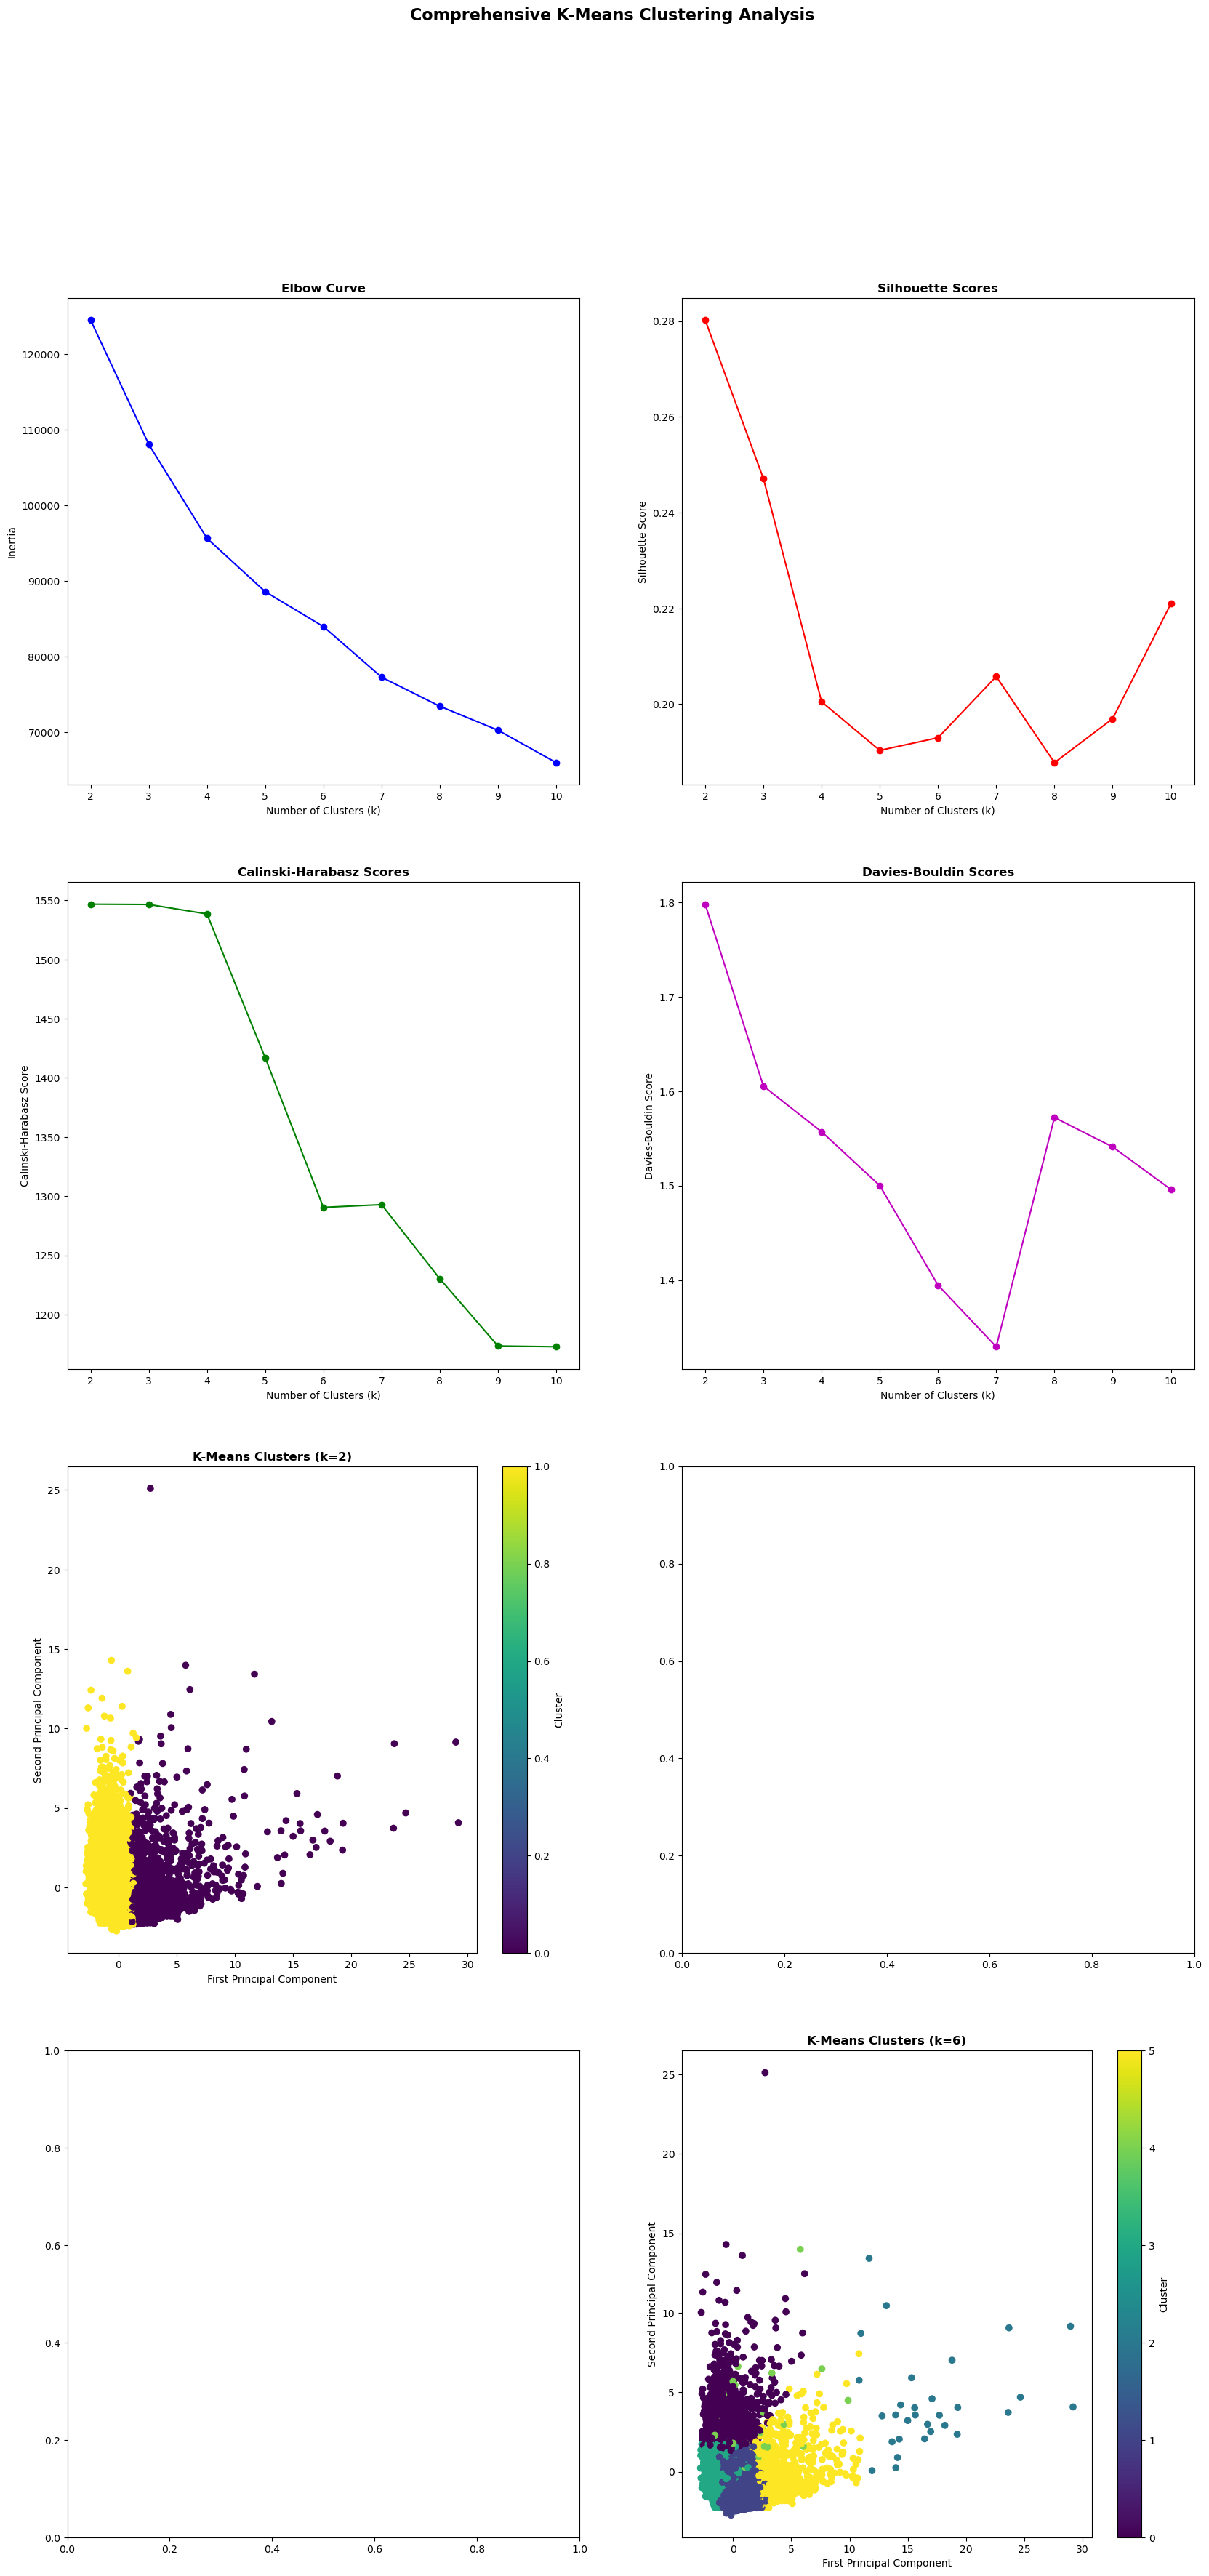

In [74]:
def preprocess_data(data: pd.DataFrame) -> np.ndarray:
    """
    Preprocesses the input data for clustering by applying StandardScaler.

    Args:
        data (pd.DataFrame): The input DataFrame containing features to be preprocessed.

    Returns:
        np.ndarray: A numpy array of preprocessed data, where each feature has been standardized.
    """
    scaler = StandardScaler()
    return scaler.fit_transform(data)


def fit_kmeans_range(data: np.ndarray, k_range: range) -> dict:
    """
    Fits K-Means clustering for a range of cluster numbers and computes relevant metrics.

    Args:
        data (np.ndarray): The preprocessed input data as a numpy array.
        k_range (range): A range object specifying the number of clusters to test.

    Returns:
        dict: A dictionary where keys are the number of clusters (k) and values are dictionaries containing:
            - 'model': The fitted KMeans model
            - 'labels': Cluster labels for each data point
            - 'inertia': The inertia score of the clustering
            - 'silhouette': The silhouette score of the clustering
    """
    results = {}
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        results[k] = {
            'model': kmeans,
            'labels': cluster_labels,
            'inertia': kmeans.inertia_,
            'silhouette': silhouette_score(data, cluster_labels),
            'calinski_harabasz': calinski_harabasz_score(data, cluster_labels),
            'davies_bouldin': davies_bouldin_score(data, cluster_labels)
        }
        
    return results


def plot_kmeans_analysis(data: np.ndarray, results: dict, k_range: range):
    """
    Creates a comprehensive plot of K-Means clustering analysis results.

    This function generates a single figure with 7 subplots:
    1. Elbow curve
    2. Silhouette scores
    3. Calinski-Harabasz scores
    4. Davies-Bouldin scores
    5-7. 2D cluster visualizations for min, median, and max k values

    Args:
        data (np.ndarray): The original high-dimensional data.
        results (dict): A dictionary of K-Means results as returned by fit_kmeans_range().
        k_range (range): The range of k values used in the analysis.

    Returns:
        None: This function does not return anything, it only produces a plot.
    """
    k_values = list(k_range)
    inertias = [results[k]['inertia'] for k in k_values]
    silhouette_scores = [results[k]['silhouette'] for k in k_values]
    ch_scores = [results[k]['calinski_harabasz'] for k in k_values]
    db_scores = [results[k]['davies_bouldin'] for k in k_values]

    # Create a figure with 4 rows and 2 columns
    fig, axes = plt.subplots(4, 2, figsize=(20, 40))
    fig.suptitle('Comprehensive K-Means Clustering Analysis', fontsize=16, fontweight='bold')

    # Elbow curve
    axes[0, 0].plot(k_values, inertias, 'bo-')
    axes[0, 0].set_xlabel('Number of Clusters (k)')
    axes[0, 0].set_ylabel('Inertia')
    axes[0, 0].set_title('Elbow Curve', fontweight='bold')

    # Silhouette scores
    axes[0, 1].plot(k_values, silhouette_scores, 'ro-')
    axes[0, 1].set_xlabel('Number of Clusters (k)')
    axes[0, 1].set_ylabel('Silhouette Score')
    axes[0, 1].set_title('Silhouette Scores', fontweight='bold')

    # Calinski-Harabasz scores
    axes[1, 0].plot(k_values, ch_scores, 'go-')
    axes[1, 0].set_xlabel('Number of Clusters (k)')
    axes[1, 0].set_ylabel('Calinski-Harabasz Score')
    axes[1, 0].set_title('Calinski-Harabasz Scores', fontweight='bold')

    # Davies-Bouldin scores
    axes[1, 1].plot(k_values, db_scores, 'mo-')
    axes[1, 1].set_xlabel('Number of Clusters (k)')
    axes[1, 1].set_ylabel('Davies-Bouldin Score')
    axes[1, 1].set_title('Davies-Bouldin Scores', fontweight='bold')

    # 2D visualizations for min, median, and max k
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)

    for i, k in enumerate([min(k_values), k_values[len(k_values)//2], max(k_values)]):
        row = i + 2
        col = i % 2
        scatter = axes[row, col].scatter(data_2d[:, 0], data_2d[:, 1], c=results[k]['labels'], cmap='viridis')
        axes[row, col].set_title(f'K-Means Clusters (k={k})', fontweight='bold')
        axes[row, col].set_xlabel('First Principal Component')
        axes[row, col].set_ylabel('Second Principal Component')
        plt.colorbar(scatter, ax=axes[row, col], label='Cluster')

    # Remove the unused subplot
    fig.delaxes(axes[2, 1])

    # Adjust the layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.975])  # Adjust the rect parameter to accommodate the suptitle
    
    # Increase spacing between subplots
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    
    plt.show()


def analyze_kmeans_clustering(data: pd.DataFrame, k_range: range):
    """
    Performs a comprehensive analysis of K-Means clustering for a range of k values.

    This function preprocesses the data, applies K-Means clustering for each k in the specified range,
    and generates a comprehensive plot to aid in the analysis of clustering results.

    Args:
        data (pd.DataFrame): The input DataFrame containing the features for clustering.
        k_range (range): A range object specifying the number of clusters to analyze.

    Returns:
        dict: A dictionary containing the detailed results of K-Means clustering for each k,
              as returned by fit_kmeans_range().

    Note:
        This function produces a single figure with multiple subplots as a side effect,
        providing a comprehensive view of the clustering analysis.
    """
    preprocessed_data = preprocess_data(data)
    results = fit_kmeans_range(preprocessed_data, k_range)

    # Generate the comprehensive plot
    plot_kmeans_analysis(preprocessed_data, results, k_range)

    return results


k_range = range(2, 11)  # Analyze for 2 to 10 clusters
kmeans_results = analyze_kmeans_clustering(data_df, k_range)

### **Preprocessing Steps**

In [13]:
numerical_variables_to_scale: list[str] = numerical_variables
nominal_categorical_variables_to_encode: list[str] = []

# Order ordinal variable categories from lowest to highest 
ordianl_categories_ordered_dict: dict[str, list[str]] = {

}
ordianl_variable_categories_to_encode: list[str] = list(ordianl_categories_ordered_dict.keys())
ordianl_variable_categories_orders_lists: list[list[str]] = list(ordianl_categories_ordered_dict.values())

# Indicates that the first column of one-hot encoded variables should be dropped to avoid multicollinearity
onehot_drop_column = "first"


# Pass in a list of tuples containing a name for the transformer (decide a name, allows transformer parameters to be searched in grid search),
# the transformer object, and the columns to apply the transformer to
general_variable_preprocessor = ColumnTransformer(
    transformers = [
        ('numerical_scaler', StandardScaler(), numerical_variables_to_scale),
        ('nominal_encoder', OneHotEncoder(drop = onehot_drop_column), nominal_categorical_variables_to_encode),
        ("ordinal_encoder", OrdinalEncoder(categories = ordianl_variable_categories_orders_lists), ordianl_variable_categories_to_encode)
    ]
)

display_markdown(md(f"### **Scaled Numerical Variables:** {numerical_variables_to_scale}"))
display_markdown(md(f"### **Encoded Nominal Categorical Variables:** {nominal_categorical_variables_to_encode}"))
display_markdown(md(f"### **Encoded Ordinal Categorical Variables (confirm that category orders were assigned to the correct ordinal categorical variable):**"))
for i in range(len(ordianl_variable_categories_to_encode)):
    display_markdown(md(f"* #### **{ordianl_variable_categories_to_encode[i]}:** {ordianl_variable_categories_orders_lists[i]}"))

### **Scaled Numerical Variables:** ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']

### **Encoded Nominal Categorical Variables:** []

### **Encoded Ordinal Categorical Variables (confirm that category orders were assigned to the correct ordinal categorical variable):**

## **Load Models and Hyperparameters**

In [23]:
def load_kmeans_model() -> dict[str, dict]:
    model_data = {
        'K-Means': {
            'model': make_pipeline(general_variable_preprocessor, KMeans(random_state=42)),
            'param_grid': {
                'kmeans__n_clusters': [2, 3, 4, 5, 6],
                'kmeans__init': ['k-means++', 'random'],
                'kmeans__n_init': [10, 20]
            }
        }
    }
    return model_data

def load_dbscan_model() -> dict[str, dict]:
    model_data = {
        'DBSCAN': {
            'model': make_pipeline(general_variable_preprocessor, DBSCAN()),
            'param_grid': {
                'dbscan__eps': [0.1, 0.5, 1.0, 1.5],
                'dbscan__min_samples': [3, 5, 10, 15]
            }
        }
    }
    return model_data

def load_gaussian_mixture_model() -> dict[str, dict]:
    model_data = {
        'Gaussian Mixture': {
            'model': make_pipeline(general_variable_preprocessor, GaussianMixture(random_state=42)),
            'param_grid': {
                'gaussianmixture__n_components': [2, 3, 4, 5, 6],
                'gaussianmixture__covariance_type': ['full', 'tied', 'diag', 'spherical']
            }
        }
    }
    return model_data

def load_hierarchical_model() -> dict[str, dict]:
    model_data = {
        'Hierarchical': {
            'model': make_pipeline(general_variable_preprocessor, AgglomerativeClustering()),
            'param_grid': {
                'agglomerativeclustering__n_clusters': [2, 3, 4, 5, 6],
                'agglomerativeclustering__linkage': ['ward', 'complete', 'average']
            }
        }
    }
    return model_data

def load_mean_shift_model() -> dict[str, dict]:
    model_data = {
        'Mean Shift': {
            'model': make_pipeline(general_variable_preprocessor, MeanShift()),
            'param_grid': {
                'meanshift__bandwidth': [None, 2, 5, 10],
                'meanshift__bin_seeding': [True, False]
            }
        }
    }
    return model_data

def load_spectral_model() -> dict[str, dict]:
    model_data = {
        'Spectral': {
            'model': make_pipeline(general_variable_preprocessor, SpectralClustering(random_state=42)),
            'param_grid': {
                'spectralclustering__n_clusters': [2, 3, 4, 5, 6],
                'spectralclustering__assign_labels': ['kmeans', 'discretize']
            }
        }
    }
    return model_data

## **Train and Test Models**

In [49]:
NUM_DECIMAL_PLACES: int = 7


models = {
    "K-Means": make_pipeline(general_variable_preprocessor, KMeans(random_state=42)),
    "DBSCAN": make_pipeline(general_variable_preprocessor, DBSCAN()),
    "Gaussian Mixture": make_pipeline(general_variable_preprocessor, GaussianMixture(random_state=42)),
    "Hierarchical": make_pipeline(general_variable_preprocessor, AgglomerativeClustering()),
    "Mean Shift": make_pipeline(general_variable_preprocessor, MeanShift()),
}


def train_and_evaluate_clustering_models(
    models_dict: Dict[str, Any] = models,
    X: pd.DataFrame = data_df,
) -> Dict[str, Dict[str, Any]]:
    """
    Trains, evaluates, and stores detailed information for all passed in clustering models.
    
    Args:
        models_dict (Dict[str, Any]): Dictionary containing model names and pipeline objects
        X (pd.DataFrame): DataFrame containing feature variables
    Returns:
        Dict[str, Dict[str, Any]]: Dictionary with model names as keys and evaluation results as values
    """
    model_results = {}
    
    # Prepare data for 2D visualization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    for model_name, model_pipeline in models_dict.items():
        display(md(f"### **Evaluating: {model_name}**"))
        
        train_start_time = time.time()
        cluster_assignments = model_pipeline.fit_predict(X)
        train_end_time = time.time()
        train_time = train_end_time - train_start_time
        display(md(f"* #### **Model Training Time:** {train_time:.2f} seconds"))
        
        unique_clusters = np.unique(cluster_assignments)
        n_clusters = len(unique_clusters)
        
        display(md(f"* #### **Number of clusters:** {n_clusters}"))
        
        # Compute clustering metrics as long as there is more than one cluster
        if n_clusters > 1:
            sil_score = silhouette_score(X, cluster_assignments)
            ch_score = calinski_harabasz_score(X, cluster_assignments)
            db_score = davies_bouldin_score(X, cluster_assignments)
            
            display(md(f"* #### **Silhouette Score:** {sil_score:.{NUM_DECIMAL_PLACES}f}"))
            display(md(f"* #### **Calinski-Harabasz Score:** {ch_score:.{NUM_DECIMAL_PLACES}f}"))
            display(md(f"* #### **Davies-Bouldin Score:** {db_score:.{NUM_DECIMAL_PLACES}f}"))
        else:
            sil_score = ch_score = db_score = np.nan
            display(md("* #### **Unable to compute clustering metrics (only one cluster found)**"))
        
        # Compute cluster sizes and centroids
        cluster_sizes = pd.Series(cluster_assignments).value_counts().sort_index()
        centroids = np.array([X[cluster_assignments == i].mean(axis=0) for i in range(n_clusters)])
        
        # Store results
        model_results[model_name] = {
            'cluster_assignments': cluster_assignments,
            'unique_clusters': unique_clusters,
            'n_clusters': n_clusters,
            'silhouette_score': sil_score,
            'calinski_harabasz_score': ch_score,
            'davies_bouldin_score': db_score,
            'train_time': train_time,
            'cluster_sizes': cluster_sizes,
            'centroids': centroids,
            'X_pca': X_pca,  # Store PCA-transformed data for visualization
        }
        
        print() 
    
    return model_results


results = train_and_evaluate_clustering_models()

### **Evaluating: K-Means**

* #### **Model Training Time:** 0.20 seconds

* #### **Number of clusters:** 8

* #### **Silhouette Score:** -0.0075621

* #### **Calinski-Harabasz Score:** 867.0471432

* #### **Davies-Bouldin Score:** 2.9326801

### **Evaluating: DBSCAN**

* #### **Model Training Time:** 0.07 seconds

* #### **Number of clusters:** 37

* #### **Silhouette Score:** -0.5709655

* #### **Calinski-Harabasz Score:** 16.8940361

* #### **Davies-Bouldin Score:** 4.2956485

### **Evaluating: Gaussian Mixture**

* #### **Model Training Time:** 0.18 seconds

* #### **Number of clusters:** 1

* #### **Unable to compute clustering metrics (only one cluster found)**

### **Evaluating: Hierarchical**

* #### **Model Training Time:** 1.52 seconds

* #### **Number of clusters:** 2

* #### **Silhouette Score:** 0.0704520

* #### **Calinski-Harabasz Score:** 346.0493458

* #### **Davies-Bouldin Score:** 3.6133149

### **Evaluating: Mean Shift**

* #### **Model Training Time:** 38.15 seconds

* #### **Number of clusters:** 77

* #### **Silhouette Score:** 0.1538557

* #### **Calinski-Harabasz Score:** 120.8887471

* #### **Davies-Bouldin Score:** 1.2762990

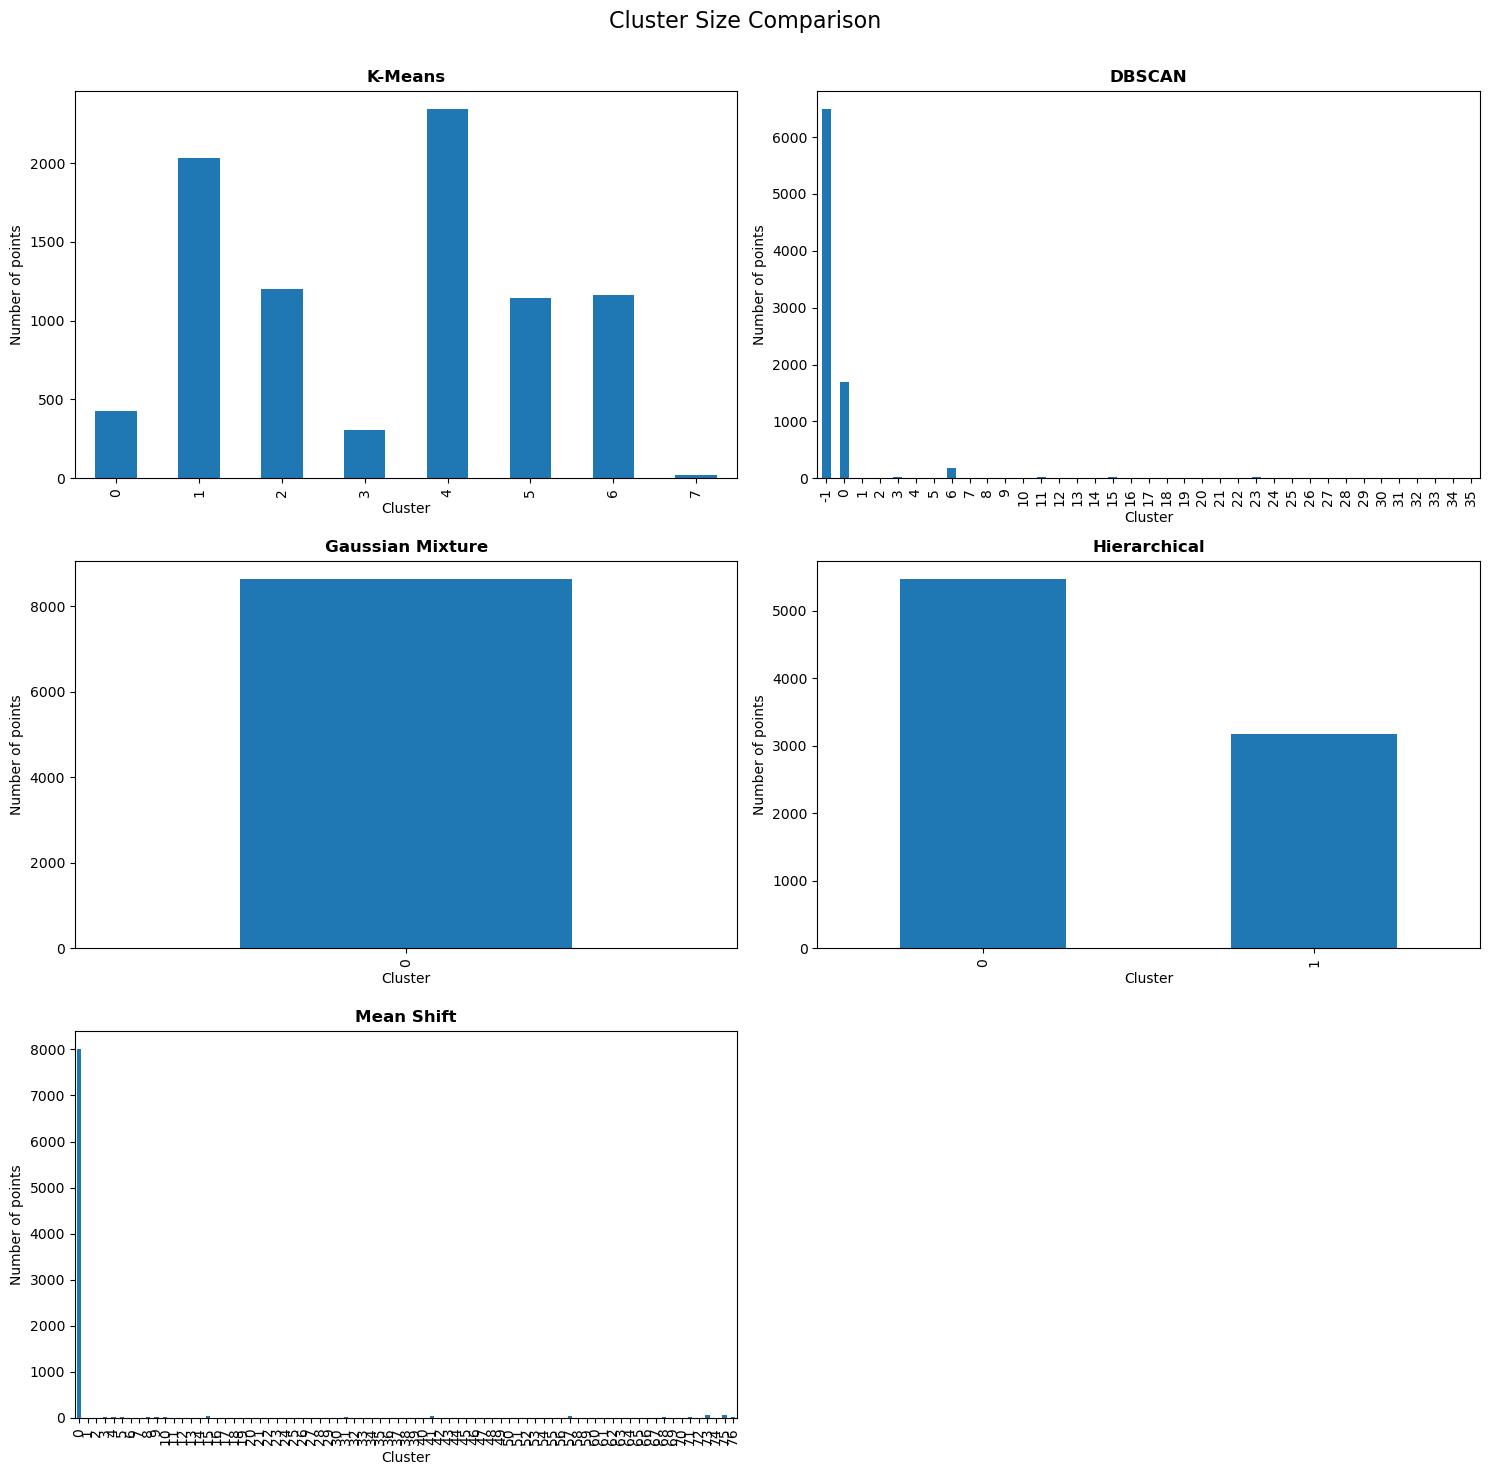

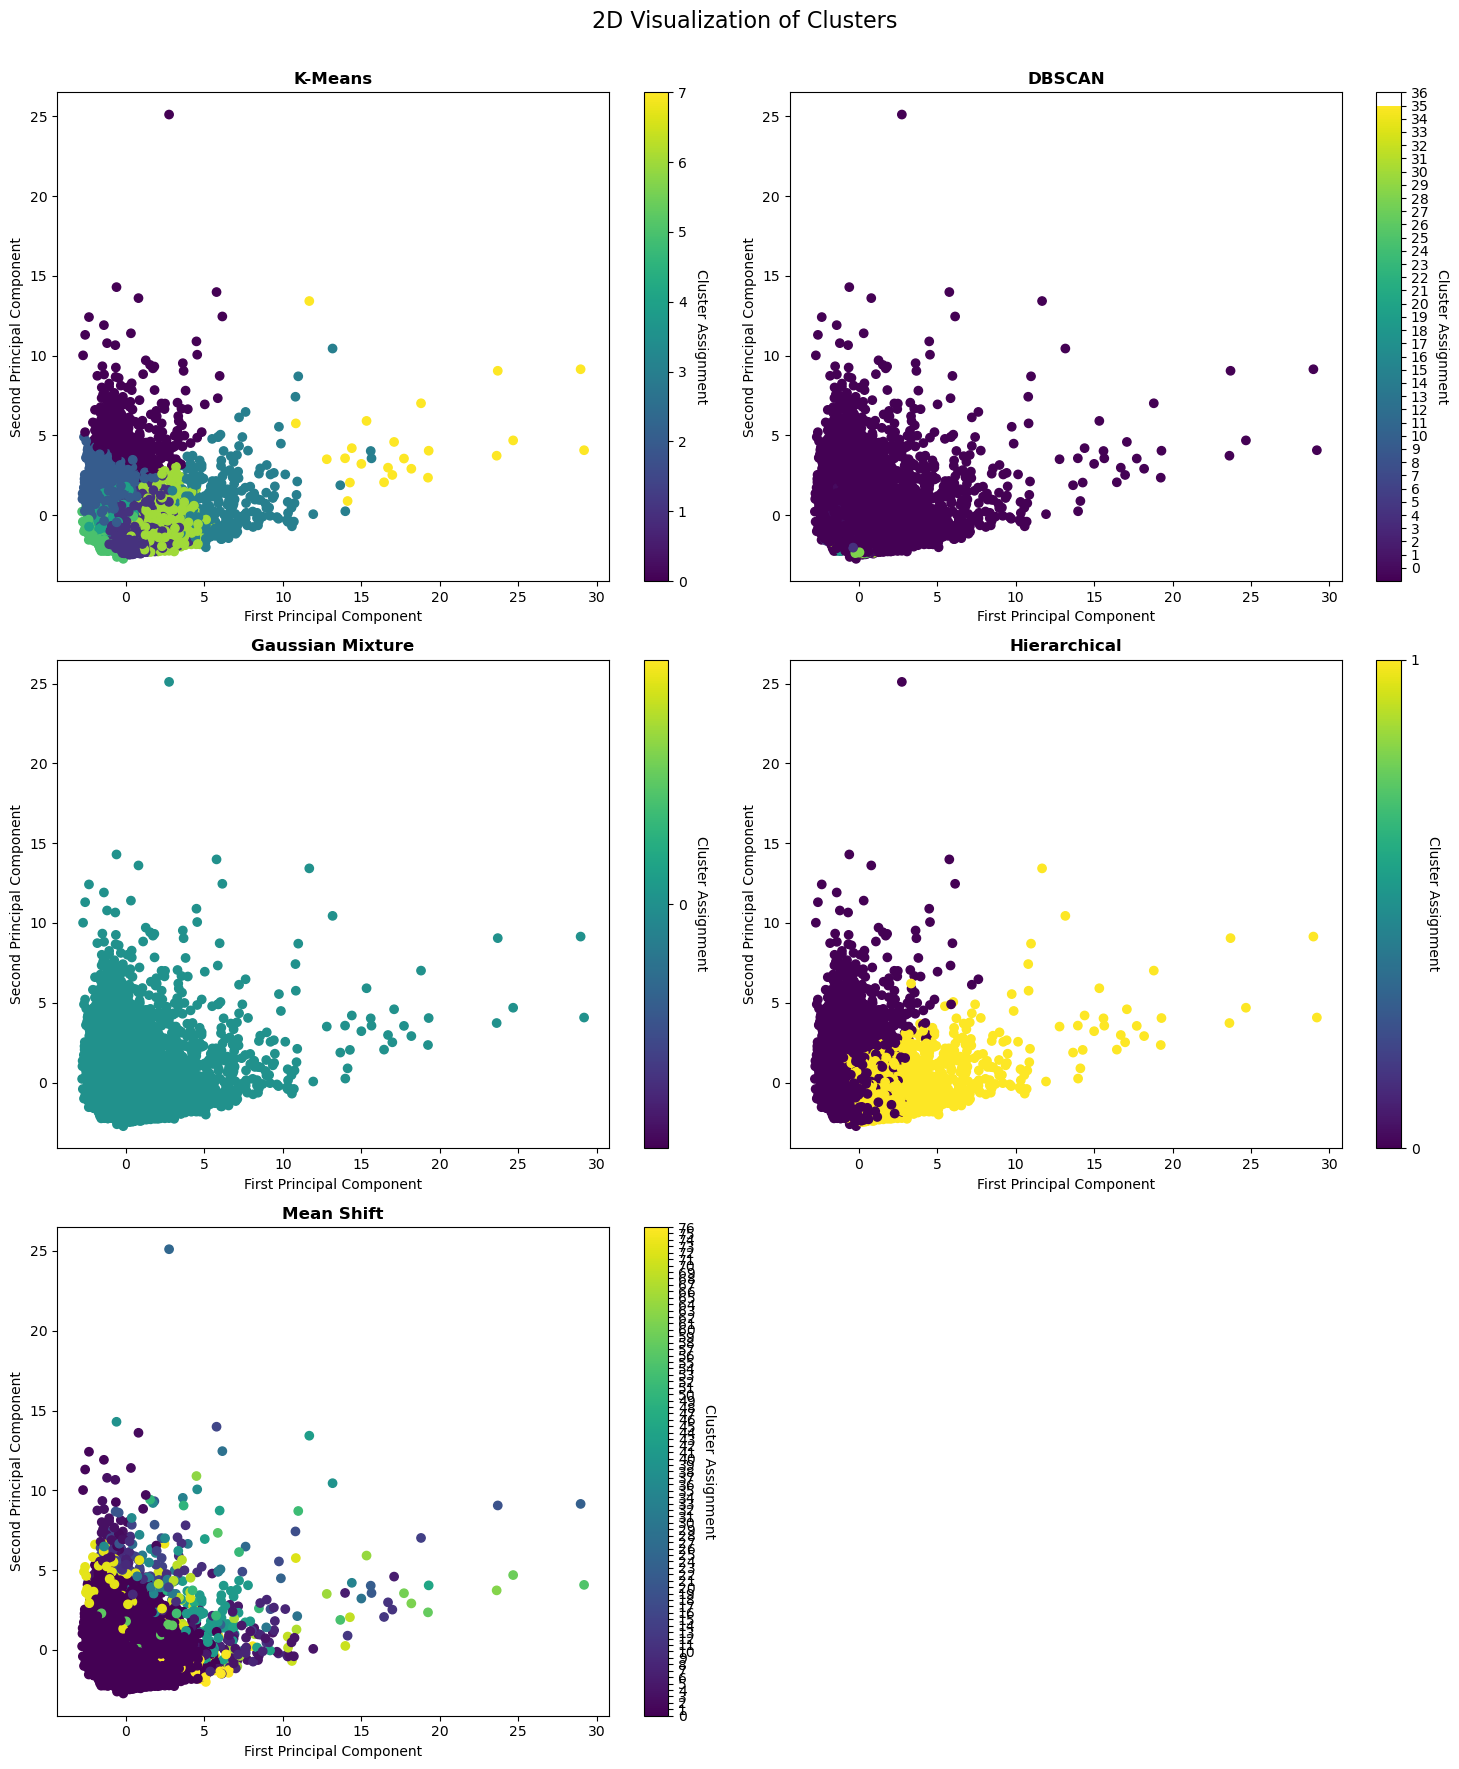

In [48]:
def plot_cluster_sizes_comparison(results):
    n_models = len(results)
    n_rows = math.ceil(n_models / 2)
    fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5*n_rows), squeeze=False)
    fig.suptitle("Cluster Size Comparison", fontsize=16)
    
    for i, (model_name, model_data) in enumerate(results.items()):
        row = i // 2
        col = i % 2
        sizes = model_data['cluster_sizes']
        ax = axes[row, col]
        sizes.plot(kind='bar', ax=ax)
        ax.set_title(model_name, fontweight = 'bold')
        ax.set_xlabel("Cluster")
        ax.set_ylabel("Number of points")
        
    # Remove any unused subplots
    for i in range(n_models, n_rows*2):
        fig.delaxes(axes[i//2, i%2])
        
    plt.tight_layout(rect=[0, 0, 1, 0.975])
    plt.show()
    
    
def plot_2d_clusters_comparison(results):
    n_models = len(results)
    n_rows = math.ceil(n_models / 2)
    fig, axes = plt.subplots(n_rows, 2, figsize=(15, 6*n_rows), squeeze=False)
    fig.suptitle("2D Visualization of Clusters", fontsize=16)
    
    for i, (model_name, model_data) in enumerate(results.items()):
        row = i // 2
        col = i % 2
        ax = axes[row, col]
        scatter = ax.scatter(model_data['X_pca'][:, 0], model_data['X_pca'][:, 1], 
                             c=model_data['cluster_assignments'], cmap='viridis')
        ax.set_title(model_name, fontweight = 'bold')
        ax.set_xlabel("First Principal Component")
        ax.set_ylabel("Second Principal Component")
        
        # Add a color bar with a more descriptive label
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Cluster Assignment', rotation=270, labelpad=15)
        
        # Adjust color bar ticks to show only integer values
        n_clusters = len(np.unique(model_data['cluster_assignments']))
        cbar.set_ticks(range(n_clusters))
        cbar.set_ticklabels(range(n_clusters))
        
    # Remove any unused subplots
    for i in range(n_models, n_rows*2):
        fig.delaxes(axes[i//2, i%2])
        
    plt.tight_layout(rect=[0, 0, 1, 0.975])
    plt.show()


plot_cluster_sizes_comparison(results)
plot_2d_clusters_comparison(results)

In [ ]:
def plot_clusters_2d(X: np.ndarray, labels: np.ndarray, title: str):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c = labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

def plot_dendrogram(linkage_matrix: np.ndarray):
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()

for model_name, result in results.items():
    if model_name != 'Hierarchical':
        plot_clusters_2d(X, result['labels'], f'{model_name} Clustering')
    else:
        plot_dendrogram(result['model'])

# Feature importance for K-Means
kmeans_model = results['K-Means']['model']
feature_importance = np.abs(kmeans_model.cluster_centers_).mean(axis=0)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, data_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance for K-Means Clustering')
plt.show()

In [30]:
NUM_DECIMAL_PLACES: int = 7


models = {
    **load_kmeans_model(),
    **load_dbscan_model(),
    **load_gaussian_mixture_model(),
    **load_hierarchical_model(),
    **load_mean_shift_model(),
    **load_spectral_model()
}


def train_and_evaluate_clustering_models(
    models_dict: Dict[str, Dict[str, Any]] = models,
    X: pd.DataFrame = data_df,
) -> Dict[str, Dict[str, Any]]:
    """
    Optimizes hyperparameters, trains, and evaluates the performance of all passed in clustering models.
    
    Args:
        models_dict (Dict[str, Dict[str, Any]]): Dictionary containing model names, objects, and param_grids
        X (pd.DataFrame): DataFrame containing feature variables

    Returns:
        Dict[str, Dict[str, Any]]: Dictionary with model names as keys and evaluation results as values
    """
    model_results = {}

    for model_name, model_data in models_dict.items():
        display_markdown(md(f"### **Evaluating: {model_name}**"))
        
        model_pipeline = model_data['model']
        cluster_assignments = model_pipeline.fit_predict(X)
        
        # Compute clustering metrics
        sil_score = silhouette_score(X, cluster_assignments)
        ch_score = calinski_harabasz_score(X, cluster_assignments)
        db_score = davies_bouldin_score(X, cluster_assignments)
        
        display_markdown(md(f"* #### **Silhouette Score:** {sil_score:.{NUM_DECIMAL_PLACES}f}"))
        display_markdown(md(f"* #### **Calinski-Harabasz Score:** {ch_score:.{NUM_DECIMAL_PLACES}f}"))
        display_markdown(md(f"* #### **Davies-Bouldin Score:** {db_score:.{NUM_DECIMAL_PLACES}f}"))
        
        # Store results
        model_results[model_name] = {
            'silhouette_score': sil_score,
            'calinski_harabasz_score': ch_score,
            'davies_bouldin_score': db_score,
            'cluster_assignments': cluster_assignments
        }
        
        print("\n")  # Add a newline for readability between models
    
    return model_results


clustering_results = train_and_evaluate_clustering_models()


### **Evaluating: K-Means**

* #### **Silhouette Score:** -0.0075621

* #### **Calinski-Harabasz Score:** 867.0471432

* #### **Davies-Bouldin Score:** 2.9326801

### **Evaluating: DBSCAN**

* #### **Silhouette Score:** -0.5709655

* #### **Calinski-Harabasz Score:** 16.8940361

* #### **Davies-Bouldin Score:** 4.2956485

### **Evaluating: Gaussian Mixture**

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

## **Results**

### Train and Evaluate Models

In [ ]:
def evaluate_clustering(X: np.ndarray, labels: np.ndarray) -> dict:
    """
    Evaluates clustering results using various metrics.
    
    Args:
        X (np.ndarray): Input data
        labels (np.ndarray): Cluster labels
    Returns:
        dict: Dictionary of evaluation metrics
    """
    if labels is None or len(np.unique(labels)) <= 1:
        return {
            'silhouette': None,
            'calinski_harabasz': None,
            'davies_bouldin': None
        }
    
    return {
        'silhouette': silhouette_score(X, labels),
        'calinski_harabasz': calinski_harabasz_score(X, labels),
        'davies_bouldin': davies_bouldin_score(X, labels)
    }

results = {}

for model_name, clustering_func in clustering_models.items():
    print(f"Clustering with {model_name}")
    
    start_time = time.time()
    model_results = clustering_func(X)
    end_time = time.time()
    
    results[model_name] = {
        'model': model_results['model'],
        'labels': model_results['labels'],
        'best_params': model_results['best_params'],
        'time': end_time - start_time
    }
    
    if results[model_name]['labels'] is not None:
        results[model_name]['evaluation'] = evaluate_clustering(X, results[model_name]['labels'])
        print(f"Number of clusters: {len(np.unique(results[model_name]['labels']))}")
        print(f"Evaluation metrics: {results[model_name]['evaluation']}")
    
    print(f"Best parameters: {results[model_name]['best_params']}")
    print(f"Time taken: {results[model_name]['time']:.2f} seconds")
    print()

### Display Functions

In [ ]:
def plot_clusters_2d(X: np.ndarray, labels: np.ndarray, title: str):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c = labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

def plot_dendrogram(linkage_matrix: np.ndarray):
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()

for model_name, result in results.items():
    if model_name != 'Hierarchical':
        plot_clusters_2d(X, result['labels'], f'{model_name} Clustering')
    else:
        plot_dendrogram(result['model'])

# Feature importance for K-Means
kmeans_model = results['K-Means']['model']
feature_importance = np.abs(kmeans_model.cluster_centers_).mean(axis=0)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, data_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance for K-Means Clustering')
plt.show()

In [ ]:
display(md("# Clustering Results Summary"))

for model_name, result in results.items():
    display(md(f"## {model_name}"))
    
    if 'evaluation' in result:
        display(md("### Evaluation Metrics"))
        for metric, value in result['evaluation'].items():
            display(md(f"- {metric.capitalize()}: {value:.4f}"))
    
    display(md(f"### Time Taken: {result['time']:.2f} seconds"))
    
    if model_name != 'Hierarchical':
        display(md(f"### Number of Clusters: {len(np.unique(result['labels']))}"))
    
    print()

# Identify the best model based on silhouette score
best_model = max(
    [model for model in results.items() if 'evaluation' in model[1]],
    key=lambda x: x[1]['evaluation']['silhouette']
)

display(md(f"# Best Performing Model: {best_model[0]}"))
display(md(f"Silhouette Score: {best_model[1]['evaluation']['silhouette']:.4}"))

In [ ]:
display_markdown(md("# Clustering Results Summary"))

for model_name, result in results.items():
    display_markdown(md(f"## {model_name}"))
    
    display_markdown(md("### Best Parameters"))
    for param, value in result['best_params'].items():
        display_markdown(md(f"- {param}: {value}"))
    
    if 'evaluation' in result:
        display_markdown(md("### Evaluation Metrics"))
        for metric, value in result['evaluation'].items():
            display_markdown(md(f"- {metric.capitalize()}: {value:.4f}"))
    
    display_markdown(md(f"### Time Taken: {result['time']:.2f} seconds"))
    
    if result['labels'] is not None:
        display_markdown(md(f"### Number of Clusters: {len(np.unique(result['labels']))}"))
    
    print()

# Identify the best model based on silhouette score
best_model = max(
    [model for model in results.items() if 'evaluation' in model[1] and model[1]['evaluation']['silhouette'] is not None],
    key=lambda x: x[1]['evaluation']['silhouette']
)

display_markdown(md(f"# Best Performing Model: {best_model[0]}"))
display_markdown(md(f"Silhouette Score: {best_model[1]['evaluation']['silhouette']:.4f}"))
display_markdown(md("### Best Parameters"))
for param, value in best_model[1]['best_params'].items():
    display_markdown(md(f"- {param}: {value}"))